###  MicroGrad demo

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from micrograd.engine import Value
from micrograd.nn import MLP

from typing import Callable, List, Tuple

In [3]:
np.random.seed(1337)
random.seed(1337)

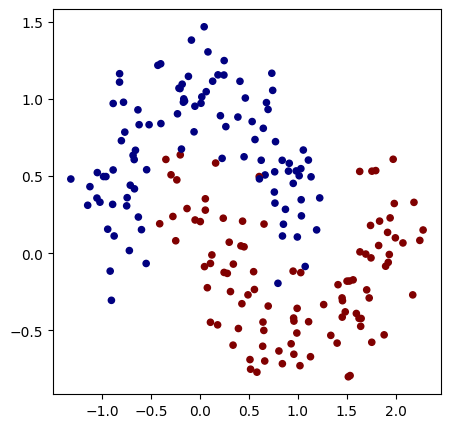

In [4]:
from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=200, noise=0.2)

y = y*2 - 1
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [5]:
print(X.shape)
print(y.shape)

(200, 2)
(200,)


In [6]:
svm_loss_model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(svm_loss_model)
print("number of parameters", len(svm_loss_model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337


In [7]:
mse_loss_model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(mse_loss_model)
print("number of parameters", len(mse_loss_model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337


In [8]:
def svm_loss(model : MLP, alpha = 1e-4, batch_size=None):
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # Forward pass: compute scores using the model
    scores = list(map(model, inputs))
    
    # Compute SVM max-margin loss
    losses = [(1 + -yi * scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    
    # Compute L2 regularization loss
    reg_loss = alpha * sum((p * p for p in model.parameters()))
    
    total_loss = data_loss + reg_loss
    
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, float(sum(accuracy)) / len(accuracy)


In [9]:
def mse_loss(model : MLP, alpha = 1e-4, batch_size=None):
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # Forward the model to get scores
    scores = list(map(model, inputs))
    
    losses = [(scorei - yi)**2 for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    
    reg_loss = alpha * sum((p * p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    

    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, float(sum(accuracy)) / len(accuracy)

In [10]:
num_epochs = 100
lr = 0.01
l2_penalty_term = 1e-4
print_interval = 5

def train_model(
    model: MLP,
    loss_func: Callable[[MLP, float, int], Tuple[Value, float]],
    num_epochs: int,
    lr: float,
    l2_penalty: float,
    batch_size: int = 32,
    print_interval: int = print_interval
) -> Tuple[List[float], List[float]]:
    """
    Trains a multi-layer perceptron (MLP) model using stochastic gradient descent (SGD).

    Args:
        model (MLP): The neural network model to be trained.
        loss_func (Callable[[MLP, float, int], Tuple[Value, float]]): 
            A function that computes the total loss and accuracy. 
            Signature: `loss_func(model, alpha, batch_size) -> (total_loss, accuracy)`.
        num_epochs (int): Number of training epochs.
        lr (float): Initial learning rate for SGD.
        l2_penalty (float): L2 regularization penalty term.
        batch_size (int, optional): Batch size for training. Defaults to 32.
        print_interval (int, optional): Number of epochs between progress printouts. Defaults to 2.

    Returns:
        Tuple[List[float], List[float]]: 
            - A list of total loss values (`total_loss.data`) for each epoch.
            - A list of accuracies for each epoch.
    """
    losses: List[float] = []
    accuracies: List[float] = []

    for epoch in range(num_epochs):
        # Compute the loss and accuracy for the current batch
        total_loss, acc = loss_func(model, l2_penalty, batch_size)
        
        # Zero the gradients
        model.zero_grad()
        total_loss.backward()
        
        
        learning_rate = lr if (loss_func == mse_loss) else (1 - 0.9*lr*epoch)  # Decaying learning rate
        for p in model.parameters():
            p.data -= learning_rate * p.grad
        
        # Store the loss and accuracy for plotting
        losses.append(total_loss.data)
        accuracies.append(acc)
        
        # Print progress at intervals
        if (epoch + 1) % print_interval == 0:
            print(f"[{epoch + 1}/{num_epochs}], Loss: {total_loss.data:.3f}, Accuracy: {acc * 100:.2f}%")

    return losses, accuracies


In [11]:
print("Training on MSE loss + Flat LR: ")
mse_losses, mse_accuracies = train_model(mse_loss_model, mse_loss, num_epochs, lr, l2_penalty_term)
print("Training on SVM loss + Decaying LR: ")
svm_losses, svm_accuracies = train_model(svm_loss_model, svm_loss, num_epochs, lr, l2_penalty_term)

Training on MSE loss + Flat LR: 
[5/100], Loss: 0.674, Accuracy: 75.00%
[10/100], Loss: 0.558, Accuracy: 78.12%
[15/100], Loss: 0.477, Accuracy: 84.38%
[20/100], Loss: 0.487, Accuracy: 84.38%
[25/100], Loss: 0.409, Accuracy: 81.25%
[30/100], Loss: 0.443, Accuracy: 84.38%
[35/100], Loss: 0.383, Accuracy: 87.50%
[40/100], Loss: 0.403, Accuracy: 90.62%
[45/100], Loss: 0.348, Accuracy: 90.62%
[50/100], Loss: 0.469, Accuracy: 81.25%
[55/100], Loss: 0.352, Accuracy: 87.50%
[60/100], Loss: 0.431, Accuracy: 87.50%
[65/100], Loss: 0.424, Accuracy: 84.38%
[70/100], Loss: 0.319, Accuracy: 87.50%
[75/100], Loss: 0.309, Accuracy: 87.50%
[80/100], Loss: 0.406, Accuracy: 84.38%
[85/100], Loss: 0.324, Accuracy: 87.50%
[90/100], Loss: 0.358, Accuracy: 87.50%
[95/100], Loss: 0.372, Accuracy: 87.50%
[100/100], Loss: 0.343, Accuracy: 90.62%
Training on SVM loss + Decaying LR: 
[5/100], Loss: 0.463, Accuracy: 87.50%
[10/100], Loss: 0.487, Accuracy: 75.00%
[15/100], Loss: 0.291, Accuracy: 90.62%
[20/100], L

In [12]:
def visualise_boundary(model : MLP):
    h = 0.25
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    Xmesh = np.c_[xx.ravel(), yy.ravel()]
    inputs = [list(map(Value, xrow)) for xrow in Xmesh]
    scores = list(map(model, inputs))
    Z = np.array([s.data > 0 for s in scores])
    Z = Z.reshape(xx.shape)

    fig = plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


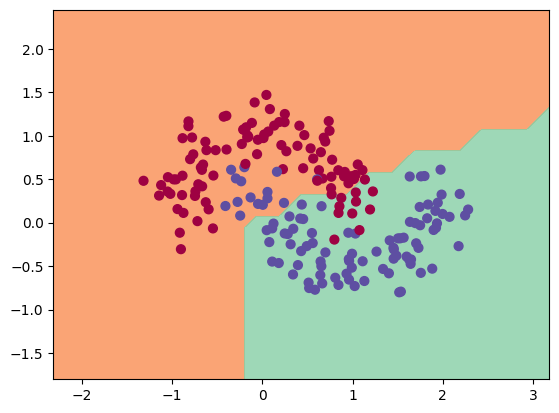

In [13]:
visualise_boundary(mse_loss_model)

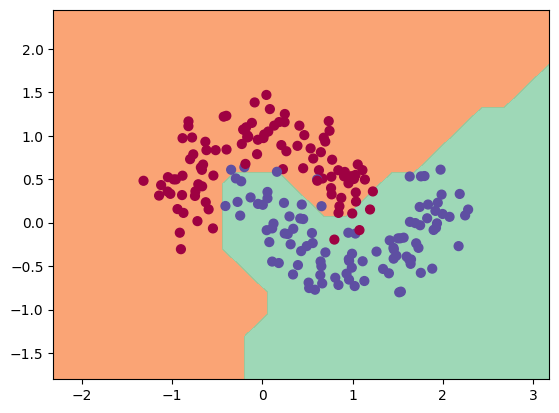

In [14]:
visualise_boundary(svm_loss_model)